## Predviđanje strukture *RNK*<a id="par:toc"></a>

U radu je razmotrena primena [probabilističkih kontekstno slobodnih gramatika](https://en.wikipedia.org/wiki/Probabilistic_context-free_grammar) (*PCFG*) i [konvolutivnih neuronskih mreža](https://en.wikipedia.org/wiki/Convolutional_neural_network) (*CNN*) u predviđanju sekundarne strukture [ribonukleinske kiseline](https://en.wikipedia.org/wiki/RNA) (*RNK*). Preuzet je skup *RNK* sa pridruženim strukturama, nakon čega je na delu podataka obučena po jedna stohastička gramatika i duboka konvolutivna mreža. Modeli su vrednovani prema uspehu na drugom delu podataka, odnosno sličnosti predviđanja sa stvarnošću.

## Sadržaj

1. [Uvod i podaci](#par:uvod)  
    1.1 [Struktura *RNK*](#par:strukt)  
    1.2 [Predviđanje strukture](#par:pred)  
    1.3 [Skup *RNAStralign*](#par:baza)  
    1.4 [Olakšani problem](#par:olak)
2. [Stohastičke gramatike](#par:stoh)  
    2.1 [Odabir gramatike](#par:kh99)  
    2.2 [Stablo izvođenja](#par:stablo)  
    2.3 [Obuka gramatike](#par:obkh)
3. [Duboka konvolucija](#par:konv)  
    3.1 [Matrica strukture](#par:mstr)  
    3.2 [Matrica sekvence](#par:msek)  
    3.3 [Priprema paketa](#par:paket)

## 1. Uvod i podaci [⮭]<a id="par:uvod"></a>

[⮭]: #par:toc

Prva glava je uvodnog tipa. Obrađeni zadatak podrazumeva predviđanje sekundarne strukture ribonukleinske kiseline, pa prvi podnaslov predstavlja kratak teorijski osvrt na strukturu *RNK*, a drugi na njenu predikciju. Treći podnaslov opisuje referentni skup podataka *RNAStralign*, koji je korišćen nadalje. Četvrti redukuje problem ograničavanjem samo na kratke sekvence, kako bi se izbegli problemi sa računskom zahtevnošću, ali uz zadržavanje biološkog smisla.

### 1.1 Struktura *RNK* [⮭]<a id="par:strukt"></a>

[⮭]: #par:toc

*RNK* je biopolimer čiju [primarnu strukturu](https://en.wikipedia.org/wiki/Nucleic_acid_sequence) gradi niz [nukleobaza](https://en.wikipedia.org/wiki/Nucleobase). U sastav sekvence ulaze četiri kanonske nukleobaze – [adenin](https://en.wikipedia.org/wiki/Adenine), [uracil](https://en.wikipedia.org/wiki/Uracil), [guanin](https://en.wikipedia.org/wiki/Guanine) i [citozin](https://en.wikipedia.org/wiki/Cytosine). Računarski gledano, *RNK* se stoga najčešće predstavlja kao niska nad azbukom $\{A, U, C, G\}$, što je skup početnih slova navedenih baza.

<img src='../slike/primarna.png' width='40%'>

Specijalno, sekvencu mogu činiti i drugi karakteri, koji predstavljaju [modifikovane baze](https://en.wikipedia.org/wiki/Nucleobase#Modified_nucleobases). Tako, na primer, [pseudouridin](https://en.wikipedia.org/wiki/Pseudouridine) (*P*) predstavlja izmenjeni [uridin](https://en.wikipedia.org/wiki/Uridine) (*U*). Ovakva modifikovanost ne doprinosi problemu predviđanja strukture i najčešće se zanemaruje, te nije ni predstavljena u poznatim bazama podataka.

Kako bi prešla u biološki aktivnu formu, *RNK* se [uvija intramolekularno](https://en.wikipedia.org/wiki/Nucleic_acid_structure), čime formira segmente uparenih nukleobaza. Takvi segmenti nazivaju se zavojnicama (*helix*) ili drškama (*stem*), dok nizovi neuparenih baza grade petlje (*loop*). U zavisnosti od oblika, postoji više različitih vrsta petlji: ukosnica (šnala, *hairpin*), unutrašnja (*interior*), razgranata (*multi-branched*), ispupčenje (*bulge*). Posebno se izdvaja i spoljašnji nestrukturirani lanac (*unstructured single strand*).

<img src='../slike/sekundarna.png' width='70%'>

Uvijanje se najčešće vizuelizuje u formi [grafa](https://en.wikipedia.org/wiki/Graph_%28discrete_mathematics%29), pri čemu su čvorovi baze, dok grane postoje između uparenih baza (označene kružićima ili lukovima), kao i između susednih elemenata sekvence (implicitne, neoznačene). Pored realističnog prikaza (*c*), popularni su i oni koji sekvencu predstavljaju na jednoj pravoj (*a*) ili na kružnici (*b*). Oni su značajni jer svedoče o ugnežđenosti uparivanja. Važan je i prikaz u formi matrice povezanosti (*d*), o čemu će biti reči u nastavku.

<img src='../slike/vizuelizacija.png' width='90%'>

Ovako formirani [bazni parovi](https://en.wikipedia.org/wiki/Base_pair) upravo čine [sekundarnu strukturu](https://en.wikipedia.org/wiki/Nucleic_acid_secondary_structure) *RNK*. Parovi $A−U$ i $G−C$ pritom su kanonski (prema Votsonu i Kriku), mada su moguće i druge ([nekanonske](https://en.wikipedia.org/wiki/Non-canonical_base_pairing)) varijante uparivanja, pri čemu se kao treći posebno izdvaja nešto manje stabilan ([*wobble*](https://en.wikipedia.org/wiki/Wobble_base_pair)), ali i dalje termodinamički povoljan par $U−G$.

<img src='../slike/familija.png' width='60%'>

Osim u formi grafa ili prostog spiska parova, sekundarnu strukturu moguće je predstaviti i kao nisku, i to nad azbukom koja se sastoji od [tačke i zagrada](https://eprints.soton.ac.uk/267292/1/RamlanEI08ExtDotBracRNA.pdf). U ovakvoj notaciji, tačka predstavlja neuparenu bazu, dok zagrade označavaju parove. Uparivanje baza, očekivano, prati matematičko i jezičko pravilo uparivanja zagrada. Podrazumevano, niske koje predstavljaju primarnu (sekvencu) i sekundarnu (uparivanje) strukturu iste *RNK* moraju biti saglasne.

<img src='../slike/pseudocvor.png' width='40%'>

U sastav sekundarne strukture ulazi nekoliko značajnih motiva. Posebno je zanimljiv strukturni motiv [ukosnice sa drškom](https://en.wikipedia.org/wiki/Stem-loop) (*stem-loop*), koji karakteriše sve ukosnice. Njegova važna odlika je da petlja sadrži najmanje tri baze, što je ograničenje koje je neophodno ugraditi u računarske metode. [Pseudočvorovi](https://en.wikipedia.org/wiki/Pseudoknot) su još jedna znamenita pojava, budući da predstavljaju neugnežđena uparivanja. Oni, međutim, zadiru u [tercijarnu](https://en.wikipedia.org/wiki/Nucleic_acid_tertiary_structure) i [kvaternarnu](https://en.wikipedia.org/wiki/Nucleic_acid_quaternary_structure) strukturu, koje nisu razmatrane.

### 1.2 Predviđanje strukture [⮭]<a id="par:pred"></a>

[⮭]: #par:toc

Problem [predviđanja strukture](https://en.wikipedia.org/wiki/Nucleic_acid_structure_prediction) *RNK* značajan je utoliko što je struktura u tesnoj vezi sa funkcijom same *RNK*, pa bi njenim određivanjem zapravo mogle biti određene mnogobrojne karakteristike razmatrane sekvence. Osim toga, eksperimentalno [utvrđivanje](https://en.wikipedia.org/wiki/Nucleic_acid_structure_determination) tačne strukture je skupo, pa se poseže za računarskim metodama. Osnovni pristup rešavanju ovog problema zasniva se na pronalaženju strukture sa najviše baznih parova i naziva se [algoritam Nusinov](https://en.wikipedia.org/wiki/Nussinov_algorithm). Datira iz 1980. godine, kada je objavljen rad [*Fast algorithm for predicting the secondary structure of single-stranded RNA*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC350273/). Sam algoritam nazvan je po autorki i svodi se na jednostavno dinamičko programiranje. Prosta maksimizacija, naravno, ne uzima u obzir važne strukturne karakteristike, pa nije preterano uspešna.

<img src='../slike/nussinov.jpg' width='60%'>

Alternativni pristup zasniva se na činjenici da intramolekularno uvijanje *RNK* diktiraju biofizički procesi, odnosno da je optimalna struktura ona sa [najnižom slobodnom energijom](https://en.wikipedia.org/wiki/Principle_of_minimum_energy). Najsofisticiraniji metod tog tipa jeste Zukerov termodinamički model, predstavljen 1989. kroz rad [*Improved predictions of secondary structures for RNA*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC298139/), a zatim dorađivan nekoliko puta, što je kulminiralo objavom alata [*mfold*](https://academic.oup.com/nar/article/31/13/3406/2904217) 2003. godine. Kasnije je objavljen veći broj sličnih alata.

<img src='../slike/zuker.png' width='50%'>

Paralelno sa termodinamičkim modelima razvijali su se oni zasnovani na statističkom učenju. Prvo su se pojavile stohastičke kontekstno slobodne gramatike, koje su zapravo duže vreme korišćene u obradi prirodnih jezika. Možda najuticajniji pristup iz tog domena jeste algoritam *KH-99*, koji su 1999. kroz rad [*RNA secondary structure prediction using stochastic context-free grammars and evolutionary history*](https://pubmed.ncbi.nlm.nih.gov/10383470/) uveli Knudsen i Hejn. Nakon dorada, 2003. je objavljen alat [*Pfold*](https://pubmed.ncbi.nlm.nih.gov/12824339/). Ubrzo je došlo do objedinjavanja termodinamičkih i statističkih modela, što je u svoje vreme bila kombinacija [vrhunske tehnologije](https://en.wikipedia.org/wiki/State_of_the_art) (*state of the art*).

Poslednjih godina su veliku popularnost stekle metode [dubokog učenja](https://en.wikipedia.org/wiki/Deep_learning), zasnovanog na različitim [veštačkim neuronskim mrežama](https://en.wikipedia.org/wiki/Artificial_neural_network). One su sada vrhunska tehnologija za rešavanje velikog broja problema, pa tako i predviđanja sekundarne strukture *RNK*. Uz probabilističke kontekstno slobodne gramatike, upravo su duboke konvolutivne neuronske mreže glavna tema ovog rada. U nastavku su modeli oba tipa obučeni, evaluirani i upoređeni prema stepenu uspeha.

### 1.3 Skup *RNAStralign* [⮭]<a id="par:baza"></a>

[⮭]: #par:toc

Manjak podataka o *RNK* dugo je pravio problem pri radu sa njima. Početkom 21. veka bilo je poznato tek nekoliko hiljada različitih sekvenci, pri čemu znatno manje struktura. Poslednjih godina, međutim, eksperimentalno je utvrđen način uvijanja velikog broja novootkrivenih [nekodirajućih](https://en.wikipedia.org/wiki/Non-coding_RNA) ribonukleinskih kiselina.

Trenutno najpoznatija baza *RNK* sa pridruženim strukturama jeste skup podataka *RNAStralign*, objavljen 2017. godine u okviru rada [*TurboFold II: RNA structural alignment and secondary structure prediction informed by multiple homologs*](https://pubmed.ncbi.nlm.nih.gov/29036420/). Ovaj skup sadrži $37.149$ struktura iz osam različitih familija *RNK* − [*16S*](https://en.wikipedia.org/wiki/16S_ribosomal_RNA) ribozomalne, [*5S*](https://en.wikipedia.org/wiki/5S_ribosomal_RNA) ribozomalne, [katalitički introni](https://en.wikipedia.org/wiki/Group_I_catalytic_intron) (*Group I Intron*), [ribonukleaze](https://en.wikipedia.org/wiki/Ribonuclease_P) (*RNaseP*), [signalne](https://en.wikipedia.org/wiki/Signal_recognition_particle_RNA) (*SRP*), [telomeraze](https://en.wikipedia.org/wiki/Telomerase), [transportno-informacione](https://en.wikipedia.org/wiki/Transfer-messenger_RNA) (*tmRNA*), [transportne](https://en.wikipedia.org/wiki/Transfer_RNA) (*tRNA*) − čija dužina varira od nekoliko desetina do skoro dve hiljade nukleobaza. Dužina, struktura i familija inače su u tesnoj vezi.

Skup *RNAStralign* sadrži identifikator sekvence, samu sekvencu, njenu familiju, kao i strukturu u obliku niza uparivanja, pri čemu indeks $j$ kao $i$-ti element niza svedoči o postojanju uparivanja $(i, j)$. Ukoliko postoji uparivanje $(i, j)$ postoji i obrnuto $(j, i)$ koje je isto. U slučaju $i = j$, baza je neuparena. Iako vrlo koristan, ovaj skup sadrži redundantne podatke. Postoje, naime, suštinski ponovljene strukture, budući da se ista ili slična *RNK* pojavljuje u više organizama. Zbog toga se pristupa uklanjanju redundantnosti kao vidu čišćenja podataka, nakon čega ostaje $30.451$ instanci. Na ovaj način dobija se [referentni](https://en.wikipedia.org/wiki/Benchmark_%28computing%29) (*benchmark*) skup, uveden u radu [*RNA Secondary Structure Prediction By Learning Unrolled Algorithms*](https://arxiv.org/abs/2002.05810) (*E2Efold*) iz 2020, a koji se koristi za upoređivanje različitih pristupa.

Dodatnim zanemarivanjem nepotpunih sekvenci, čija struktura nije precizno određena, dobija se konačan broj od $28.473$ sloga. Pomenuti rad preporučuje [podelu](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets) na skupove za obučavanje (trening), proveru (test) i validaciju u približnom odnosu $80\%−10\%−10\%$, i to [stratifikovanu](https://en.wikipedia.org/wiki/Stratified_sampling) prema familiji. Štaviše, oni su dostupni kroz tri datoteke u formatu zapetom razdvojenih vrednosti, pa se u nastavku sveske koriste kao `train.csv`, `test.csv` i `valid.csv`. Sledi implementacija klase koja enkapsulira *RNK* sekvencu sa pridruženim identifikatorom, familijom i strukturom, a može i da je nacrta, kao i učita podatke.

In [1]:
# Biblioteka za crtanje
from ipynb.draw import draw_struct

# Biblioteka za vizuelizacije
from matplotlib import pyplot as plt

In [2]:
# Klasa koja predstavlja RNK
class RNK:
    # Konstrukcija objekta prema podacima
    def __init__(self, identifikator, sekvenca, familija, *uparivanje):
        self.id = identifikator
        self.sekvenca = sekvenca
        self.familija = familija
        self.uparivanje = [*map(int, uparivanje)]
        
        # Inicijalizacija strukture
        struktura = len(sekvenca) * ['.']
        
        # Popunjavanje strukture uparivanjima
        for i, j in enumerate(self.uparivanje):
            if i < j:
                struktura[i] = '('
                struktura[j] = ')'
        
        # Spajanje strukture u jednu nisku
        self.struktura = ''.join(struktura)
    
    # Crtanje enkapsulirane sekundarne strukture
    def _ipython_display_(self):
        draw_struct(self.sekvenca, self.struktura, ax=plt.gca())
        
        # Dodavanje naslova ilustraciji
        plt.title('\n'.join([f'{self.id} [{self.familija}]', self.sekvenca,
                             self.struktura]), fontdict={'family': 'monospace'})
        
        # Sređivanje grafikona
        plt.tight_layout()
    
    # Učitavanje podataka iz datoteke
    def učitaj(datoteka):
        with open(datoteka) as f:
            return [RNK(*l.split(',')) for l in f.readlines()]

In [3]:
# Učitavanje skupova sa diska
train = RNK.učitaj('../podaci/train.csv')
test = RNK.učitaj('../podaci/test.csv')
valid = RNK.učitaj('../podaci/valid.csv')

Nakon učitavanja, korisno je [analizirati](https://en.wikipedia.org/wiki/Exploratory_data_analysis) podatke. Za početak, tabelarno je predstavljena raspodela instanci po familijama i skupovima za trening, test i validaciju. Najzastupljenije su ribozomalna i transportna *RNK*, dok telomeraza ima simbolično malo. Podela stvarno jeste stratifikovana. Prikazane su i statistike koje se odnose na dužinu sekvenci unutar familije. Ubedljivo je najkraća transportna, a isto tako ubedljivo najduža *16S* ribozomalna *RNK*.

In [4]:
# Biblioteka za rad sa nizovima
import numpy as np

# Biblioteka za rad sa tabelama
import pandas as pd

# Biblioteka za grupisanje instanci
from itertools import groupby

In [5]:
# Spisak dostupnih skupova podataka
skupovi = ['svi', 'train', 'test', 'valid']

# Spisak osam familija koje su deo baze
familije = np.unique([rnk.familija for rnk in valid])

# Spojeni spisak za potrebe analize skupa
svi = sorted(train + test + valid, key=lambda rnk: rnk.familija)

# Spisak zanimljivih statistika
agregacije = ['min', 'max', 'mean', 'std']

In [6]:
# Grupisanje instanci po familiji
def po_familiji(podaci):
    return groupby(globals()[podaci], lambda rnk: rnk.familija)

# Statistika nad odabranim skupom
def statistika(funkcija, skup):
    return [getattr(np, funkcija)
            ([len(rnk.sekvenca) for rnk in familija])
            for _, familija in po_familiji(skup)]

In [7]:
# Tabelarni prikaz raspodele familija
def tabela_familija():
    # Inicijalno prazna tabela raspodele
    tabela = pd.DataFrame(index=familije)
    
    # Brojčana zastupljenost svake familije po skupovima
    for skup in skupovi:
        tabela[skup] = statistika('count_nonzero', skup)
    
    # Statistike svake familije u spojenom skupu
    for agg in agregacije:
        tabela[agg] = statistika(agg, 'svi')
    
    # Sortiranje tabele prema zastupljenosti familije
    tabela.sort_values(by='svi', ascending=False, inplace=True)
    
    # Sumiranje po familijama u specijalni red
    for skup in skupovi:
        tabela.loc[' ', skup] = tabela[skup].sum()
    
    # Statistike po familijama u specijalni red
    for agg in agregacije:
        tabela.loc[' ', agg] = getattr(tabela[agg], agg)()
    
    # Prikaz generisane celobrojne tabele
    display(tabela.astype(np.int32))

In [8]:
# Tabelarni prikaz raspodele familija
tabela_familija()

,svi,train,test,valid,min,max,mean,std
16S_rRNA_database,9792,7742,1023,1027,54,1829,1210,373
5S_rRNA_database,9706,7593,1069,1044,104,132,118,3
tRNA_database,7112,5387,858,867,64,95,76,5
group_I_intron_database,773,597,88,88,163,615,397,69
SRP_database,448,348,52,48,30,533,256,94
tmRNA_database,448,364,44,40,32,437,352,65
RNaseP_database,157,128,17,12,189,486,349,61
telomerase_database,37,29,4,4,382,559,444,37
,28473,22188,3155,3130,30,1829,400,119


Tabela prikazuje apsolutnu raspodelu instanci po familijama. S druge strane, moguće je iskoristiti [pitu](https://en.wikipedia.org/wiki/Pie_chart) kako bi se prikazala relativna raspodela. U nastavku je, jednostavnosti radi, prikazana pita samo za spojeni skup, ali iz prethodne tabele je jasno da bi identično izgledala na tri stratifikovano podeljena skupa.

In [9]:
# Pitičast prikaz raspodele familija
def pita_familija():
    # Brojčana zastupljenost svake familije
    zastupljenost = np.array(statistika('count_nonzero', 'svi'))
    
    # Relativna zastupljenost iz brojčane
    zastupljenost = zastupljenost/zastupljenost.sum()
    
    # Pita koja prikazuje relativnu zastupljenost
    kriške, _ = plt.pie(zastupljenost)
    
    # Oznake sa nazivom familije i njenim udelom
    oznake = [f'{i} [{j:.2%}]' for i, j in zip(familije, zastupljenost)]
    
    # Sortiranje kriški i oznaka prema zastupljenosti
    kriške, oznake, _ =  zip(*sorted(zip(kriške, oznake, zastupljenost),
                                     key=lambda x: x[2], reverse=True))
    
    # Ucrtavanje legende van pite zbog preklapanja
    plt.legend(kriške, oznake, bbox_to_anchor=(0, .75))
    
    # Sređivanje grafikona
    plt.tight_layout()

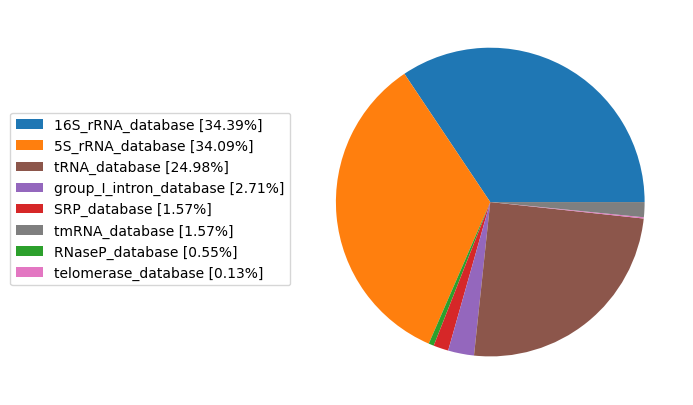

In [10]:
# Pitičast prikaz raspodele familija
pita_familija()

Kako je prikazana raspodela familija, tako se može prikazati i raspodela dužina sekvenci. To je najpogodnije uraditi upotrebom [histograma](https://en.wikipedia.org/wiki/Histogram). Iz ovog prikaza jasno je da tri podeljena skupa nisu stratifikovana samo po familiji, već i po dužini sekvenci. Jasno se izdvajaju najduže *16S* ribozomalne *RNK*, čija je prosečna dužina sekvence preko hiljadu nukleobaza. Jasno se izdvajaju i sekvence do stotinak nukleobaza, koje mahom pripadaju transportnoj *RNK*.

In [11]:
# Histogram raspodele dužina
def histogram_dužina():
    # Spiskovi dužina u svakom skupu
    dužine = [[len(rnk.sekvenca)
               for rnk in globals()[skup]]
               for skup in skupovi]
    
    # Pravljenje podgrafika za skupove
    fig, axs = plt.subplots(2, 2, figsize=(9, 4),
                            sharex=True, sharey=True)
    
    # Prolazak kroz sve skupove
    for ax, dužina, skup in zip(axs.ravel(), dužine, skupovi):
        # Histogram gustine tekućeg skupa
        ax.hist(dužina, density=True)
        
        # Ime skupa kao naslov histograma
        ax.set_title(skup)
    
    # Sređivanje grafikona
    fig.tight_layout()

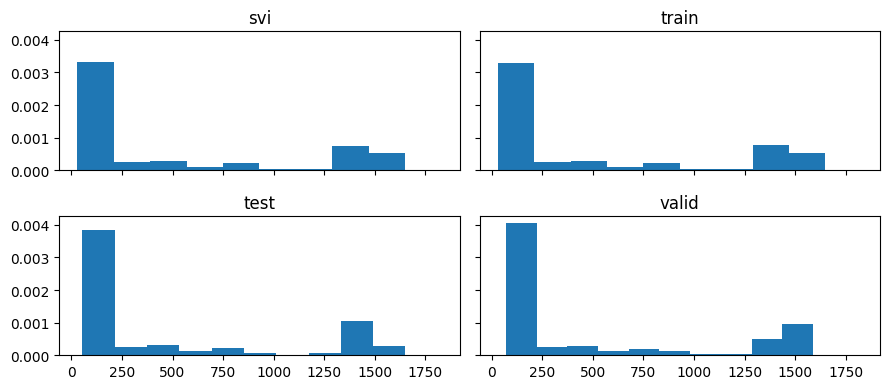

In [12]:
# Histogram raspodele dužina
histogram_dužina()

### 1.4 Olakšani problem [⮭]<a id="par:olak"></a>

[⮭]: #par:toc

Kako je već nagovešteno, postoji tesna veza između dužine *RNK* sekvence, njene strukture i familije kojoj pripada. Stoga je čest motiv u literaturi pravljenje ansambla modela koji su trenirani nad sekvencama različitih dužina. Ispostavlja se da oni daju primetno bolje rezultate od pojedinačnog modela nad celim skupom. U ansamblu, dakle, postoji jedan model za sekvence kraće od neke trocifrene granice, a drugi za duže, mahom kompleksnu ribozomalnu *RNK*.

U nastavku je, zbog toga, fokus samo na jednoj familiji, i to transportnoj *RNK*, skraćeno nazvanoj *tRNK*. Ova familija najčešće se modeluje kao [detelina s tri lista](https://en.wikipedia.org/wiki/Cloverleaf_model_of_tRNA), mada to nije sasvim precizna karakterizacija. Ima ulogu u [prenošenju](https://en.wikipedia.org/wiki/Translation_%28biology%29) aminokiselina i njihovoj ugradnji u proteine čija je sinteza u toku. Odabrana je prvenstveno zbog toga što je najkraća, što umnogome smanjuje računsku zahtevnost obučavanja i provere modela. Obučeni modeli mogli bi se koristiti u okviru ansambla za predviđanje strukture kratkih sekvenci, pogotovu ako je poznato da predstavljaju *tRNK*. Prikazan je jedan primer iz skupa za obuku.

In [13]:
# Odabir familije transportnih RNK
familije = ['tRNA_database']

In [14]:
# Odabir familije nad učitanim skupovima
train = [rnk for rnk in train if rnk.familija in familije]
test = [rnk for rnk in test if rnk.familija in familije]
valid = [rnk for rnk in valid if rnk.familija in familije]

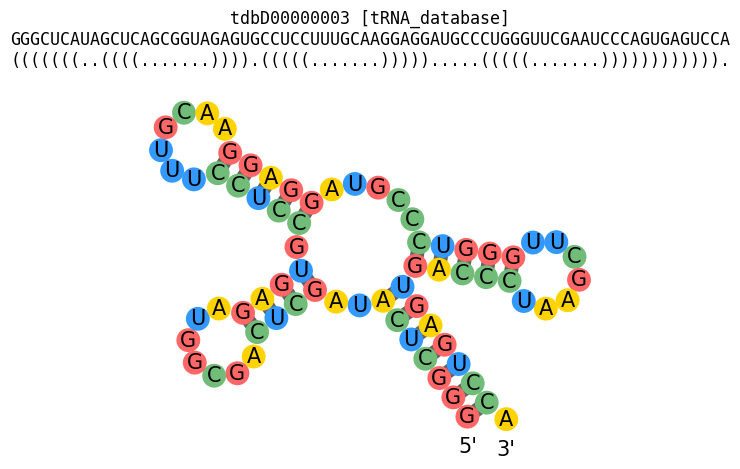

In [15]:
# Ilustracija strukture jedne tRNK
train[0]

Modeli koji su razmatrani u nastavku formiraju glomazne strukture na osnovu sekvence, kao što su stabla i kvadratne matrice. Kako bi lakše mogli da se isprate ti koraci, uvodi se veštački primer dužine trideset nukleobaza. Ovaj primer ima znatno manje baza, ali strukturno odgovara transportnoj *RNK*.

In [16]:
# Mali primer sekvence
primer = RNK('Mali primer', 'GUUAGCAUCGCGGGAACCUUUGGAACCAUG', 'tRNK',
             28, 27, 2, 3, 10, 9, 6, 7, 8, 5, 4, 11, 17, 16, 14, 15,
             13, 12, 18, 19, 20, 26, 25, 23, 24, 22, 21, 1, 0, 29)

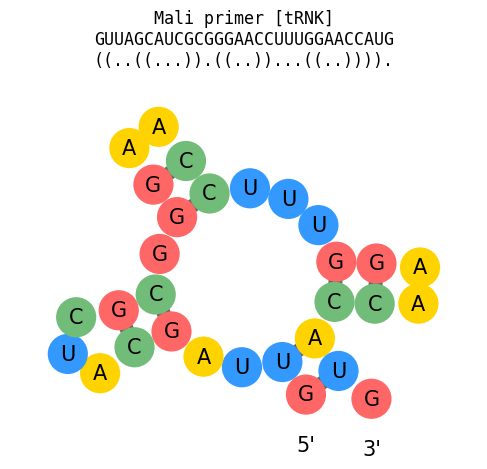

In [17]:
# Struktura malog primera
primer

## 2. Stohastičke gramatike [⮭]<a id="par:stoh"></a>

[⮭]: #par:toc

[Formalna gramatika](https://en.wikipedia.org/wiki/Formal_grammar) određena je konačnim skupom simbola i pravila izvođenja. Simboli mogu biti apstraktni neterminali (nezavršni), ali i konkretni terminali (završni), koji se pojavljuju u rečenicama modelovanog jezika. Terminali u slučaju *RNK* odgovaraju već pomenutoj azbuci nukleobaza $\{A, U, C, G\}$, dok skup neterminala zavisi od gramatike, ali obavezno sadrži početni neterminal $S$ (kao *start*). Pravila izvođenja data su u obliku $\alpha \rightarrow \beta$, gde su $\alpha$ i $\beta$ nizovi simbola.

Kontekstno slobodne gramatike odlikuje ograničenje da je leva strana pravila ($\alpha$) strogo jedan neterminal, dok je desna ($\beta$) proizvoljan niz simbola. Stohastičke gramatike dodatno svakom pravilu izvođenja pridružuju verovatnoću, i to dobro definisanu, tako da je pokriven ceo prostor događaja, odnosno da se verovatnoća svih mogućih izvođenja iz jednog neterminala sumira u jedinicu. Ispostavlja se da stohastičke ili [probabilističke kontekstno slobodne gramatike](https://en.wikipedia.org/wiki/Probabilistic_context-free_grammar) (*PCFG*), koja objedinjuju ove dve odlike, predstavljaju dobar statistički model jezika sa ugnežđenim zavisnostima, a jedan takav jezik upravo je jezik *RNK*.

### 2.1 Odabir gramatike [⮭]<a id="par:kh99"></a>

[⮭]: #par:toc

Kako je napomenuto u uvodu, *PCFG* su uz termodinamičke modele dugo bile vrhunski pristup predviđanju sekundarne strukture ribonukleinskih kiselina. Pritom se *KH-99* izdvaja kao jedna od najuticajnijih i najuspešnijih gramatika, pa je upravo ona implementirana u nastavku. Gramatika je sledećeg oblika:

$$ \large S → LS \scriptsize\text{ (nizanje elemenata) } \large| L \scriptsize\text{ (poslednji element) } $$
$$ \large L → s \scriptsize\text{ (neuparena baza) } \large| dFd \scriptsize\text{ (početak zavojnice) } $$
$$ \large F → dFd \scriptsize\text{ (nastavak zavojnice) } \large| LS \scriptsize\text{ (unutrašnjost zavojnice) } $$

Pored obaveznog startnog simbola $S$, od kog počinje izvođenje nizanjem elemenata, ova jednostavna gramatika sadrži još samo dva neterminala, koji prirodno modeluju uvijanje *RNK*. Neterminal $L$ (*loop*) pritom označava elemente koji se nižu, a to su pojedinačne baze ili zavojnice, dok $F$ (*fold*) razvija započetu zavojnicu. Konkretni terminali su na shemi apstrahovani simbolima $s$ (pojedinačna baza, *single*) i $d$ (uparena baza, *double*). Primetno je da se uparivanja ocenjuju afino: različito ona na početku zavojnice i ona unutar nje. Na taj način uveden je osnovni, ali značajan kontekst, što se ogleda u dobrim rezultatima. Minimalna dužina petlje je dva, sa izvođenjem $F → LS → sS → sL → ss$, a gramatika je jednoznačna za poznatu strukturu.

Naravno, postoji dosta drugih gramatika. Najjednostavija je zasnovana na u uvodu pomenutom maksimizacionom algoritmu Nusinov. Ukoliko su dozvoljena prazna (epsilon) pravila izvođenja, moguća je sledeća kompaktna forma: $S → dSd | SS | s | \epsilon$. Pritom, dakle, $\epsilon$ predstavlja kraj izvođenja. Pravilo $S → SS$ omogućava grananje, a time i postojanje većeg broja zavojnica i petlji. Ukoliko prazna pravila nisu dozvoljena, gramatika je: $S → dSd$ (uparivanje) $| SS$ (grananje) $| s$ (neuparena baza). Minimalna dužina petlje je nula (sa praznim) ili jedan (bez praznih), a postoji ograničavajuća višeznačnost grananja.

Iako su kontekstno slobodne gramatike, sasvim prirodno, oslobođene od konteksta, on im se može donekle pridodati pažljivo smišljenim pravilima izvođenja. Primera radi, pravilo $S → kS$ može se prepisati kao $S → kS^k$. Novi neterminal $S^k$ uvodi se za svaki terminal $k$ i u suštini poznaje svoj kontekst: u pitanju je $S$ koje se nalazi upravo iza simbola $k$. Ovakvo usložnjavanje gramatike naziva se [markovizacija](https://www3.nd.edu/~dchiang/teaching/nlp/2016/notes/chapter13v2.pdf) i predstavlja jedan od načina za povećavanje opisne moći. Sličan princip primenjuje upravo *KH-99*, čiji neterminali $L$ i $F$ donekle poznaju odakle su došli. Kako je već rečeno, odvojeno se ocenjuju početna uparivanja.

Posebnu primenu u modelovanju familija *RNK* i njihove strukture imaju modeli kovarijacije (kovarijacioni ili kovarijansni modeli, *CM*), uvedeni 1994. u radu [*RNA sequence analysis using covariance models*](https://pubmed.ncbi.nlm.nih.gov/8029015/). Reč je o gramatikama čija pravila izvođenja podrazumevaju postojanje dobro očuvanog skeleta strukture u familiji koja se modeluje. Ovakva pravila, očekivano, nose sa sobom najviše konteksta, ali su najsloženija i strogo ograničena na konkretnu familiju. Poznata baza kovarijacionih modela sa pridruženim višestrukim poravnanjima, saglasnim strukturama i mnogim metodama analize i vizuelizacije jeste [*Rfam*](https://rfam.xfam.org/).

### 2.2 Stablo izvođenja [⮭]<a id="par:stablo"></a>

[⮭]: #par:toc

Obučavanje gramatike svodi se na [procenu maksimalne verovatnoće](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation), što znači da se njeni parametri, a to su verovatnoće pravila izvođenja, postavljaju tako da su uočeni podaci iz skupa za obuku najverovatniji. To je moguće prostim prebrojavanjem i uprosečavanjem primenjenih pravila tokom obuke, pri čemu nije uobičajena upotreba [regularizacije](https://en.wikipedia.org/wiki/Regularization_%28mathematics%29). Podatke je prethodno potrebno pripremiti u obliku stabala izvođenja, kako bi gramatika mogla da se obuči nad njima.

Podsećanja radi, dosad je razmatrana reprezentacija sekvence kao niske, strukture kao niske ili niza uparivanja, sekvence i strukture zajedno kao grafa. Sada je neophodno sekvencu i strukturu zajedno predstaviti u formi stabla izvođenja u odabranoj gramatici. Kako je kod gramatike *KH-99* svako izvođenje sekvence jednoznačno za poznatu strukturu (jednoj anotiranoj sekvenci odgovara tačno jedno drvo izvođenja i obrnuto), ovo je lako moguće uraditi algoritmom poput [rekurzivnog spusta](https://en.wikipedia.org/wiki/Recursive_descent_parser), kakav je i implementiran u nastavku uz pomoć poznate biblioteke [*NLTK*](https://www.nltk.org/index.html) za obradu prirodnih jezika i prikazan na malom primeru *tRNK*.

In [18]:
# Biblioteka za rad sa stablima
from nltk import Tree

In [19]:
# Kontekstno slobodna gramatika KH-99
def KH99(rnk):
    # Obrada startnog neterminala S[i:j]
    def S(i, j):
        # Jedan karakter mora biti neuparena baza
        # pa je izvođenje S[i:j] → L[i:j]
        if i == j:
            return Tree('S', [L(i, j)])
        
        # Neuparena baza je u suprotnom u petlji,
        # pa je izvođenje S[i:j] → L[i:i] S[i+1:j]
        if rnk.struktura[i] == '.':
            return Tree('S', [L(i, i), S(i+1, j)])
        
        # Određivanje uparene baze
        k = rnk.uparivanje[i]
        
        # Potpuno uparivanje znači da je izvođenje
        # u nekoj zavojnici: S[i:j] → L[i:j]
        if j == k:
            return Tree('S', [L(i, j)])
        
        # Nepotpuno uparivanje uslovljava grananje,
        # pa je izvođenje S[i:j] → L[i:k] S[k+1:j]
        return Tree('S', [L(i, k), S(k+1, j)])
    
    # Obrada neterminala petlje L[i:j]
    def L(i, j):
        # Najlevlji (tekući) ribonukleotid
        rn_i = rnk.sekvenca[i]
        
        # Jedan karakter mora biti neuparena baza,
        # pa je izvođenje tipa L[i:j] → s
        if i == j:
            return Tree('L', [rn_i])
        
        # Određivanje uparene baze
        rn_j = rnk.sekvenca[j]
        
        # Potpuno uparivanje znači da je izvođenje
        # u zavojnici: L[i:j] → d F[i+1:j-1] d
        return Tree('L', [rn_i, F(i+1, j-1), rn_j])
    
    # Obrada neterminala zavojnice F[i:j]
    def F(i, j):
        # Neuparena baza je u unutrašnjosti heliksa,
        # pa je izvođenje F[i:j] → L[i:i] S[i+1:j]
        if rnk.struktura[i] == '.':
            return Tree('F', [L(i, i), S(i+1, j)])

        # Najlevlji (tekući) ribonukleotid
        rn_i = rnk.sekvenca[i]
        
        # Određivanje uparene baze
        k = rnk.uparivanje[i]
        rn_k = rnk.sekvenca[k]
        
        # Potpuno uparivanje znači da je izvođenje
        # u zavojnici: F[i:j] → d F[i+1:j-1] d
        if j == k:
            return Tree('F', [rn_i, F(i+1, j-1), rn_k])
        
        # Nepotpuno uparivanje uslovljava grananje,
        # pa je izvođenje F[i:j] → L[i:k] S[k+1:j]
        return Tree('F', [L(i, k), S(k+1, j)])
    
    # Izvođenje cele sekvence iz startnog neterminala
    return S(0, len(rnk.sekvenca)-1)

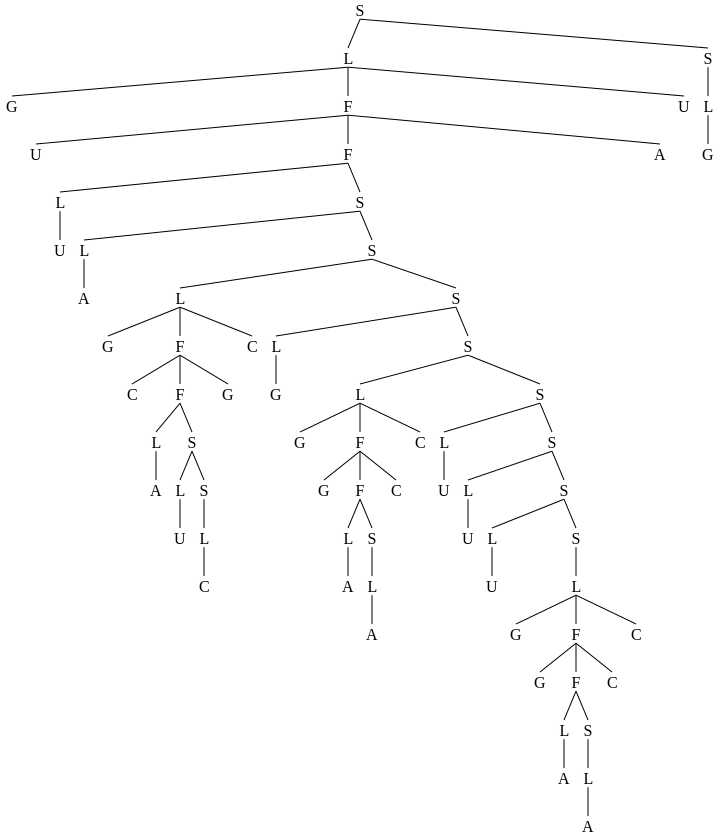

In [20]:
# Mali primer u gramatici KH-99
display(KH99(primer))

### 2.3 Obuka gramatike [⮭]<a id="par:obkh"></a>

[⮭]: #par:toc

Kada je ceo skup za obuku predstavljen u vidu stabala izvođenja, moguće je pristupiti obučavanju modela, koje podrazumeva i indukciju same gramatike. Trening se, dakle, svodi na jednostavno prebrojavanje primenjenih pravila, a primenjena pravila direktno se dobijaju iz stabla izvođenja. Naime, moguće je obilaskom svakog stabla izvući niz primenjenih pravila izvođenja, na osnovu kojih je nadalje moguće odrediti verovatnoće izvođenja u gramatici.

U nastavku je implementirana klasa koja enkapsulira gramatiku *KH-99*, nakon čega je gramatika obučena, a njena pravila izvođena prikazana. Uvidom u obučenu gramatiku, odnosno njene parametre, moguće je izvesti različite zaključke. Primera radi, može se primetiti da je ubedljivo najčešće uparivanje $G-C$, za koje je poznato da je termodinamički najstabilnije. Na drugom mestu je obrnuti par $C-G$, dok je dva do tri puta manje parova $A-U$ i $U-A$. Postoji i određeni nezanemarljivi broj nekanonskih parova $U-G$ i $G-U$. Takođe, u petljama su primetno češće baze $A$ i $U$, dok su $G$ i $C$ uparenije.

In [21]:
# Biblioteka za rad sa PCFG
from nltk import induce_pcfg, Nonterminal, ViterbiParser

In [22]:
# Stohastička kontekstno slobodna gramatika
class PCFG:
    # Pravljenje i obučavanje gramatike
    def __init__(self, train):
        self.gramatika = self.obuči(train)
        
        # Sortiranje pravila radi lepšeg prikaza
        self.gramatika.productions().sort(
            key=lambda p: (p.lhs(), len(p.rhs()), p.prob()), reverse=True)
        
        # Pravljenje parsera nad gramatikom
        self.parser = ViterbiParser(self.gramatika)
    
    # Prikaz gramatike u konzoli
    def _ipython_display_(self):
        print(self.gramatika)
    
    # Pravljenje i obučavanje gramatike
    def obuči(self, train):
        # Izdvajanje svih stabala izvođenja
        train = map(KH99, train)
        
        # Izdvajanje svih pravila izvođenja
        pravila = [p for t in train for p in t.productions()]
        
        # Indukcija gramatike nad pravilima
        return induce_pcfg(Nonterminal('S'), pravila)
    
    # Pravljenje strukture na osnovu drveta
    @staticmethod
    def od_drveta(*drvo):
        # Ukoliko je list, neuparena je baza
        if isinstance(drvo[0], str):
            if len(drvo) == 1:
                return '.'
            
            # Tročlano izvođenje je uparivanje
            if len(drvo) == 3:
                return '(' + PCFG.od_drveta(*drvo[1]) + ')'
        
        # Sva ostala izvođenja se razlažu
        return ''.join(PCFG.od_drveta(*d) for d in drvo)
    
    # Predviđanje jedne strukture
    def predvidi(self, test):
        # Izdvajanje sekvence testne RNK
        sekvenca = test.sekvenca
        
        # Formiranje stabla izvođenja
        stablo = self.parser.parse_one(sekvenca)
        
        # Formiranje strukture prema stablu
        return PCFG.od_drveta(*stablo)

In [23]:
# Obučena gramatika KH-99
pcfg = PCFG(train)

In [24]:
# Prikaz instancirane gramatike
pcfg

Grammar with 19 productions (start state = S)
    S -> L S [0.840738]
    S -> L [0.159262]
    L -> 'G' F 'C' [0.0594802]
    L -> 'C' F 'G' [0.0194104]
    L -> 'G' F 'U' [0.014591]
    L -> 'A' F 'U' [0.0105732]
    L -> 'U' F 'A' [0.00888146]
    L -> 'U' F 'G' [0.00159335]
    L -> 'U' [0.267703]
    L -> 'A' [0.255098]
    L -> 'G' [0.206924]
    L -> 'C' [0.155745]
    F -> 'G' F 'C' [0.306886]
    F -> 'C' F 'G' [0.244489]
    F -> 'U' F 'A' [0.113188]
    F -> 'A' F 'U' [0.0929114]
    F -> 'G' F 'U' [0.0206922]
    F -> 'U' F 'G' [0.0202854]
    F -> L S [0.201547]


## 3. Duboka konvolucija [⮭]<a id="par:konv"></a>

[⮭]: #par:toc

...

### 3.1 Matrica strukture [⮭]<a id="par:mstr"></a>

[⮭]: #par:toc

...

In [25]:
# Prikaz stilizovane tabele
def stilizuj(tabela, cmap):
    display(tabela.style.background_gradient(cmap=cmap, axis=None))

In [26]:
# Određivanje matrice strukture
def matrica_strukture(rnk, crtaj=False):
    # Dužina RNK sekvence
    n = len(rnk.uparivanje)
    
    # Inicijalizacija praznih uparivanja
    parovi = np.zeros((n, n), dtype=np.int8)
    
    # Popunjavanje svakog uparivanja
    parovi[range(n), rnk.uparivanje] = 1
    
    # Crtanje stilizovane tabele uparivanja
    if crtaj:
        stilizuj(pd.DataFrame(parovi), 'Purples')
    # Ili vraćanje izračunate matrice parova
    else:
        return np.expand_dims(parovi, 0)

In [27]:
# Matrica strukture malog primera
matrica_strukture(primer, crtaj=True)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 3.2 Matrica sekvence [⮭]<a id="par:msek"></a>

[⮭]: #par:toc

...

In [28]:
# Mapiranje baza u cele brojeve
baze = dict(zip('AUGC', range(4)))

In [29]:
# Izračunavanje matrice sekvence
def matrica_sekvence(rnk, razmak=3, crtaj=False):
    # Dužina RNK sekvence
    n = len(rnk.sekvenca)
    
    # Celobrojno enkodirana sekvenca
    sekvenca = np.array([baze[s] for s in rnk.sekvenca])
    
    # Matrično predstavljena sekvenca
    j = np.tile(sekvenca, (n, 1))
    
    # Transponat matrične sekvence
    i = j.transpose(1, 0)
    
    # Maska za enkodiranje parova
    maska = np.max(np.stack(((np.abs(i-j)==1), +
                             np.eye(n, dtype=np.int8))), 0)
    
    # Enkodiranje parova pomoću maske
    jedan = (i*4 + j + 1) * maska
    
    # Zanemarivanje uparivanja koja su preblizu
    for i in range(1, razmak+1):
        jedan[range(n - i), range(i, n)] = 0
        jedan[range(i, n), range(n - i)] = 0
    
    # Dodavanje nove dimenzije na početak
    jedan = np.expand_dims(jedan, 0)
    
    # Inicijalizacija matrice parova
    matrica = np.zeros((17, n, n), dtype=np.int8)
    
    # Matrično predstavljanje indeksa
    idx2 = np.tile(np.arange(n), (n, 1))
    idx1 = idx2.transpose(1, 0).reshape(-1)
    idx2 = idx2.reshape(-1)
    
    # Popunjavanje matrice uparivanjima
    matrica[jedan.reshape(-1), idx1, idx2] = 1
    
    # Odbacivanje prve, nevažne dimenzije
    matrica = matrica[1:]
    
    # Prvih šest kanala su dozvoljena uparivanja,
    # što su redom A-U, U-A, U-G, G-U, G-C, C-G
    osam = matrica[[1, 4, 6, 9, 11, 14]]
    
    # Sedmi kanal dele neuparene baze, za koje se
    # može zamisliti da su uparene same sa sobom
    osam = np.concatenate((osam, np.expand_dims(np.sum(matrica[[0, 5, 10, 15]], 0), 0)), 0)
    
    # Osmi kanal dele nedozvoljena uparivanja, što
    # uključuje biološki moguća, ali previše bliska
    osam = np.concatenate((osam, 1-np.expand_dims(np.sum(osam, 0), 0)), 0)
    
    # Crtanje stilizovane tabele enkodiranja
    if crtaj:
        # Izračunavanje matrice enkodiranja
        prikaz = [[np.argmax(j) for j in i] for i in osam.transpose(1, 2, 0)]
        
        # Prikaz stilizovane tabele enkodiranja
        stilizuj(pd.DataFrame(prikaz), 'Pastel1')
    # Ili vraćanje izračunate matrice parova
    else:
        return osam

In [30]:
# Matrica strukture malog primera
matrica_sekvence(primer, crtaj=True)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,6,7,7,7,7,4,7,3,4,7,4,7,7,7,7,7,4,4,3,3,3,7,7,7,7,4,4,7,3,7
1,7,6,7,7,7,7,1,7,7,2,7,2,2,2,1,1,7,7,7,7,7,2,2,1,1,7,7,1,7,2
2,7,7,6,7,7,7,1,7,7,2,7,2,2,2,1,1,7,7,7,7,7,2,2,1,1,7,7,1,7,2
3,7,7,7,6,7,7,7,0,7,7,7,7,7,7,7,7,7,7,0,0,0,7,7,7,7,7,7,7,0,7
4,7,7,7,7,6,7,7,7,4,7,4,7,7,7,7,7,4,4,3,3,3,7,7,7,7,4,4,7,3,7
5,5,7,7,7,7,6,7,7,7,5,7,5,5,5,7,7,7,7,7,7,7,5,5,7,7,7,7,7,7,5
6,7,0,0,7,7,7,6,7,7,7,7,7,7,7,7,7,7,7,0,0,0,7,7,7,7,7,7,7,0,7
7,2,7,7,1,7,7,7,6,7,7,7,2,2,2,1,1,7,7,7,7,7,2,2,1,1,7,7,1,7,2
8,5,7,7,7,5,7,7,7,6,7,7,7,5,5,7,7,7,7,7,7,7,5,5,7,7,7,7,7,7,5
9,7,3,3,7,7,4,7,7,7,6,7,7,7,7,7,7,4,4,3,3,3,7,7,7,7,4,4,7,3,7


### 3.3 Priprema paketa [⮭]<a id="par:paket"></a>

[⮭]: #par:toc

...

In [31]:
# Priprema paketa za prosleđivanje mreži
def pripremi(uzorak):
    # Određivanje matrice svake sekvence
    x = [matrica_sekvence(rnk) for rnk in uzorak]
    
    # Određivanje matrice svake strukture
    y = [matrica_strukture(rnk) for rnk in uzorak]
    
    # Vraćanje naslaganih vrednosti
    return np.stack(x), np.stack(y)

In [32]:
# Pravljenje paketa sa malim primerom
paket = pripremi([primer])

# Dimenzije ulaza paketa sa malim primerom
print(paket[0].shape, '→ ulaz')

# Dimenzije izlaza paketa sa malim primerom
print(paket[1].shape, '→ izlaz')

(1, 8, 30, 30) → ulaz
(1, 1, 30, 30) → izlaz
